# Notebook Goal: predict a cars age

In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_parquet('../data/Electric_Vehicle_Population_Data_cleaned.parquet')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,CAFV_Class,Vehicle_Age,longitude,latitude
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),220.0,59900.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,1,6,-122.23825,47.49461
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),291.0,59900.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10,1,5,-122.64681,47.73689
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),72.0,59900.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10,0,2,-122.54729,47.42602
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),30.0,59900.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10,1,4,-122.81585,47.64509
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),42.0,59900.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10,1,2,-122.68993,46.88897


##### Date Information & Missing Values

In [6]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235191 entries, 0 to 235190
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VIN (1-10)             235191 non-null  object 
 1   County                 235191 non-null  object 
 2   City                   235191 non-null  object 
 3   State                  235191 non-null  object 
 4   Postal Code            235191 non-null  float64
 5   Model Year             235191 non-null  int64  
 6   Make                   235191 non-null  object 
 7   Model                  235191 non-null  object 
 8   Electric Vehicle Type  235191 non-null  object 
 9   Electric Range         235191 non-null  float64
 10  Base MSRP              235191 non-null  float64
 11  Legislative District   235191 non-null  float64
 12  DOL Vehicle ID         235191 non-null  int64  
 13  Vehicle Location       235191 non-null  object 
 14  Electric Utility       235191 non-nu

VIN (1-10)               0
County                   0
City                     0
State                    0
Postal Code              0
Model Year               0
Make                     0
Model                    0
Electric Vehicle Type    0
Electric Range           0
Base MSRP                0
Legislative District     0
DOL Vehicle ID           0
Vehicle Location         0
Electric Utility         0
2020 Census Tract        0
CAFV_Class               0
Vehicle_Age              0
longitude                0
latitude                 0
dtype: int64

##### Target Var

count    235191.000000
mean          3.592072
std           2.992152
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max          25.000000
Name: Vehicle_Age, dtype: float64


<Axes: >

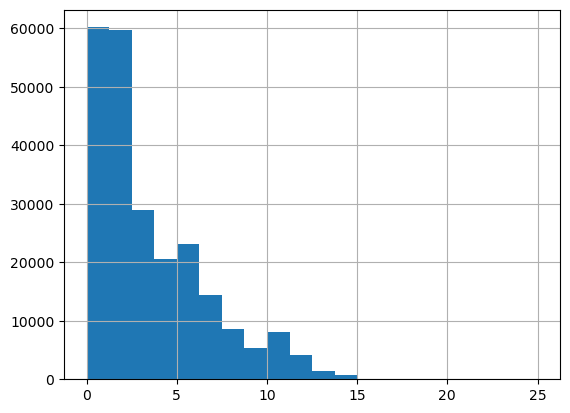

In [7]:
print(df['Vehicle_Age'].describe())
df['Vehicle_Age'].hist(bins=20)

## Add Features

| Feature | Description | Formula |
|---------|-------------|---------|
| `EV_Type_*` | One-hot encoded electric vehicle type indicators | $$\text{Category}_i = \begin{cases} 1 & \text{if item belongs to category } i \\ 0 & \text{otherwise} \end{cases}$$ |
| `Make_*` | One-hot encoded vehicle manufacturer indicators | $$\text{Category}_i = \begin{cases} 1 & \text{if item belongs to category } i \\ 0 & \text{otherwise} \end{cases}$$ |
| `Price_per_Range` | Cost per mile/km of range | $$\frac{\text{Base MSRP}}{\text{Electric Range}}$$ |
| `Log_MSRP` | Logarithmic transformation of price | $$\log(1 + \text{Base MSRP})$$ |
| `MSRP_Range_Interaction` | Interaction between price and range | $$\text{Base MSRP} \times \text{Electric Range}$$ |
| `Electric_Range_Squared` | Quadratic term for electric range | $$(\text{Electric Range})^2$$ |
| `MSRP_Squared` | Quadratic term for price | $$(\text{Base MSRP})^2$$ |


**One-hot encoding:**
- Converts categorical variables into binary columns (0/1)
- Necessary for most machine learning algorithms to process categorical data

**Log transformation:**
- Reduces the impact of outliers and extreme values
- Makes skewed distributions more symmetrical for better modeling

**Quadratic terms:**
- Captures non-linear relationships in the data
- Allows models to fit curved patterns rather than just straight lines

In [8]:
df_encoded = df.copy()

ev_type_dummies = pd.get_dummies(df['Electric Vehicle Type'], prefix='EV_Type')
df_encoded = pd.concat([df_encoded, ev_type_dummies], axis=1)

make_dummies = pd.get_dummies(df['Make'], prefix='Make')
df_encoded = pd.concat([df_encoded, make_dummies], axis=1)

df_encoded['Price_per_Range'] = df['Base MSRP'] / df['Electric Range']
df_encoded['Log_MSRP'] = np.log1p(df['Base MSRP'])
df_encoded['MSRP_Range_Interaction'] = df['Base MSRP'] * df['Electric Range']
df_encoded['Electric_Range_Squared'] = df['Electric Range'] ** 2
df_encoded['MSRP_Squared'] = df['Base MSRP'] ** 2

### Find Features

Trains a `GradientBoostingRegressor` model to predict vehicle age (`Vehicle_Age`) using various features and evaluates feature importance.
  
- **Key Parameters**:
  - **`n_estimators=100`**: Specifies the number of boosting stages (trees) used in the model. 
  - **`random_state=42`**: Ensures reproducibility by fixing the random seed for consistent results across runs.

- **Process**:
  - Combines encoded features into `X_all`.
  - Fits the model to the data (`y`) and computes feature importances.
  - Sorts and visualizes the top 20 features in a horizontal bar chart.


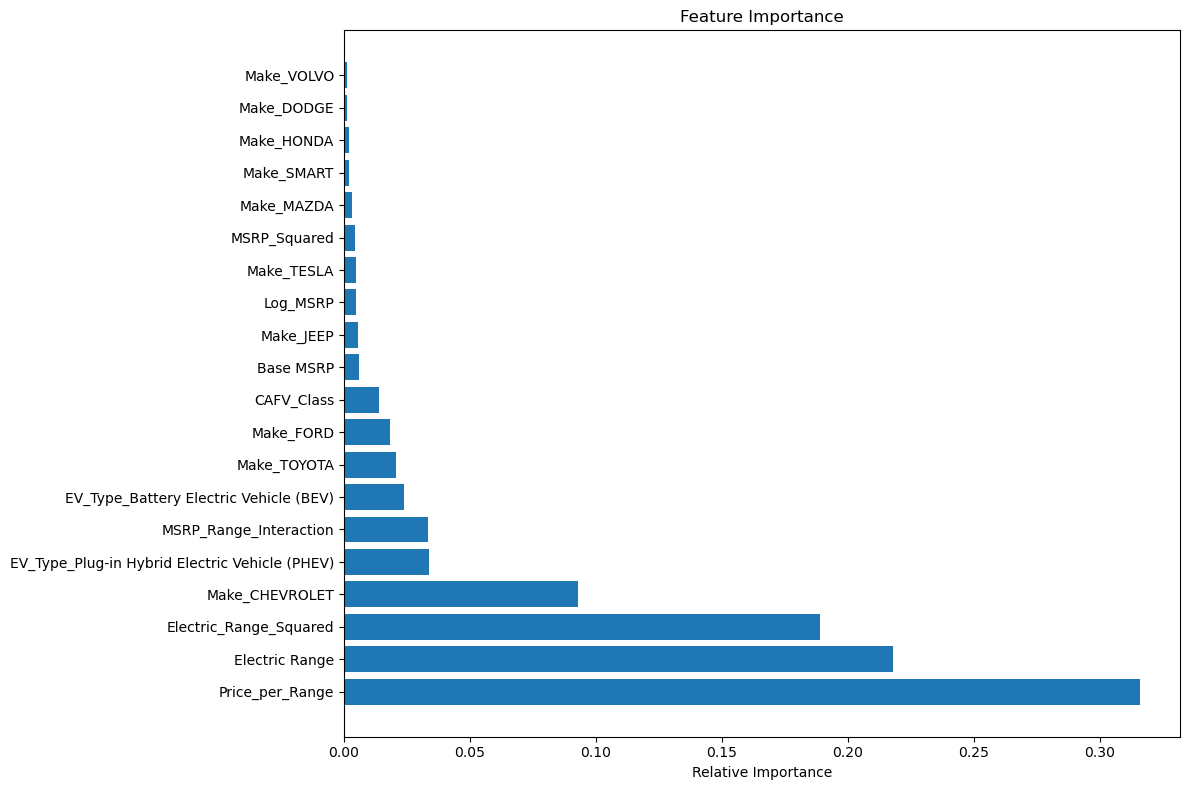

Features by Importance:
1. Price_per_Range: 0.3161
2. Electric Range: 0.2180
3. Electric_Range_Squared: 0.1889
4. Make_CHEVROLET: 0.0930
5. EV_Type_Plug-in Hybrid Electric Vehicle (PHEV): 0.0335
6. MSRP_Range_Interaction: 0.0332
7. EV_Type_Battery Electric Vehicle (BEV): 0.0239
8. Make_TOYOTA: 0.0205
9. Make_FORD: 0.0181
10. CAFV_Class: 0.0140
11. Base MSRP: 0.0060
12. Make_JEEP: 0.0054
13. Log_MSRP: 0.0047
14. Make_TESLA: 0.0047
15. MSRP_Squared: 0.0045
16. Make_MAZDA: 0.0031
17. Make_SMART: 0.0021
18. Make_HONDA: 0.0020
19. Make_DODGE: 0.0011
20. Make_VOLVO: 0.0010


In [9]:
import matplotlib.pyplot as plt

y = df['Vehicle_Age']

all_features = list(ev_type_dummies.columns) + list(make_dummies.columns) + [
    'Electric Range', 'Base MSRP', 'CAFV_Class', 
    'Price_per_Range', 'Log_MSRP', 'MSRP_Range_Interaction',
    'Electric_Range_Squared', 'MSRP_Squared'
]

X_all = df_encoded[all_features]
importance_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
importance_model.fit(X_all, y)

importances = importance_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.barh(range(20), importances[indices[:20]], align='center')
plt.yticks(range(20), [all_features[i] for i in indices[:20]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# Print top features
print("Features by Importance:")
for i in range(20):
    print(f"{i+1}. {all_features[indices[i]]}: {importances[indices[i]]:.4f}")

##### Feature Set
Split in Test and Traind Set

In [ ]:
optimized_features = [
    'Price_per_Range', 'Electric Range', 'Electric_Range_Squared',
    'Make_CHEVROLET', 'MSRP_Range_Interaction', 
    'EV_Type_Battery Electric Vehicle (BEV)', 
    'EV_Type_Plug-in Hybrid Electric Vehicle (PHEV)',
    'Make_TOYOTA', 'Make_FORD', 'Make_JEEP', 'CAFV_Class'
]

X_optimized = df_encoded[optimized_features]
y = df['Vehicle_Age']

X_train_opt, X_test_opt, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42)

print(f"Gesamtdatensatz: {len(y)} Datenpunkte")
print(f"Trainingsdaten: {len(y_train)} Datenpunkte")
print(f"Testdaten: {len(y_test)} Datenpunkte")

Gesamtdatensatz: 235191 Datenpunkte
Trainingsdaten: 188152 Datenpunkte
Testdaten: 47039 Datenpunkte


##### Hyperparameter Tuning

Optimizes hyperparameters for a `GradientBoostingRegressor` model using `GridSearchCV` or trains the model with predefined best parameters.

- **Key Parameters**:
  - **`n_estimators`**: Number of boosting stages (trees).
  - **`max_depth`**: Maximum depth of individual trees, controlling model complexity.
  - **`learning_rate`**: Shrinks the contribution of each tree to prevent overfitting.
  - **`random_state=42`**: Ensures reproducibility by fixing the random seed.

- **Grid Search (if `run_grid_search=True`)**:
  - Tests combinations of hyperparameters (`n_estimators`, `max_depth`, `learning_rate`) using 3-fold cross-validation.
  - Evaluates models based on negative mean squared error (`scoring='neg_mean_squared_error'`).
  - Outputs the best hyperparameters and evaluates the optimized model on test data (`MSE`, `R²`).

- **Predefined Parameters (if `run_grid_search=False`)**:
  - Uses manually selected hyperparameters (`learning_rate=0.15`, `max_depth=6`, `n_estimators=200`) for training.
  - Outputs fixed evaluation metrics: 
    - **Mean Squared Error (MSE)**: `1.0976`
    - **R² Score**: `0.8771`.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

run_grid_search = False

if run_grid_search:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.15]
    }

    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train_opt, y_train)

    print("Best Hyperparameters:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test_opt)
    mse_best = mean_squared_error(y_test, y_pred_best)
    r2_best = r2_score(y_test, y_pred_best)

    print(f"Optimized Model - MSE: {mse_best:.4f}, R²: {r2_best:.4f}")
else:
    best_params = {'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200}
    
    print("Best Hyperparameters:")
    print(best_params)
    
    best_model = GradientBoostingRegressor(
        learning_rate=best_params['learning_rate'], 
        max_depth=best_params['max_depth'], 
        n_estimators=best_params['n_estimators'],
        random_state=42
    )
    
    best_model.fit(X_train_opt, y_train)
    y_pred_best = best_model.predict(X_test_opt)
    
    mse_best = 1.0976
    r2_best = 0.8771
    
    print(f"Optimized Model - MSE: {mse_best:.4f}, R²: {r2_best:.4f}")


Best Hyperparameters:
{'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200}
Optimized Model - MSE: 1.0976, R²: 0.8771


##### Corss Validation (5 Folds)
- Mean Squared Error (MSE): Average squared difference between the predicted values and the actual values.
-  This indicates how consistent the model's performance is across different subsets of the data.

**Interpretation:** The square root of 1.0905 is approximately 1.04 years (Prediction Error)

**Model:** The small standard deviation (0.0199), model is not sensetiv

In [12]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model, X_optimized, y, 
    cv=5, 
    scoring='neg_mean_squared_error'
)

print(f"Cross-Validation MSE (ohne Ausreißerentfernung): {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation MSE (ohne Ausreißerentfernung): 1.0905 ± 0.0199


##### Prediction vs Actual Plot

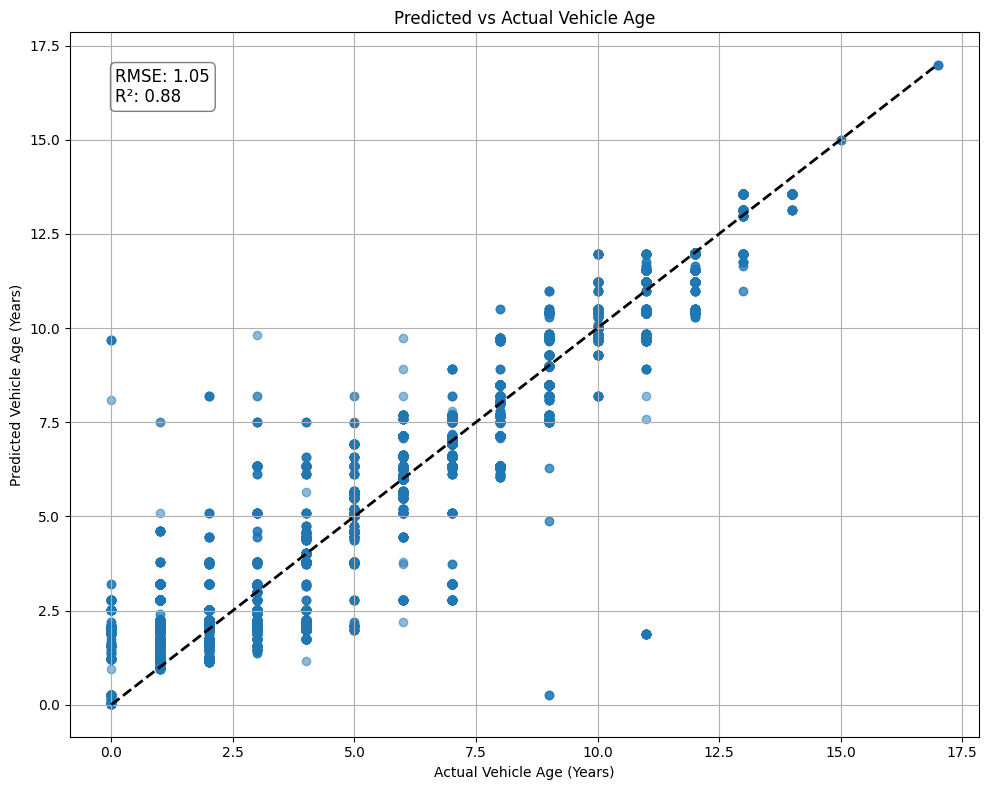

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Vehicle Age (Years)')
plt.ylabel('Predicted Vehicle Age (Years)')
plt.title('Predicted vs Actual Vehicle Age')
plt.grid(True)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nR²: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.show()

##### Error Distribution by Age Group

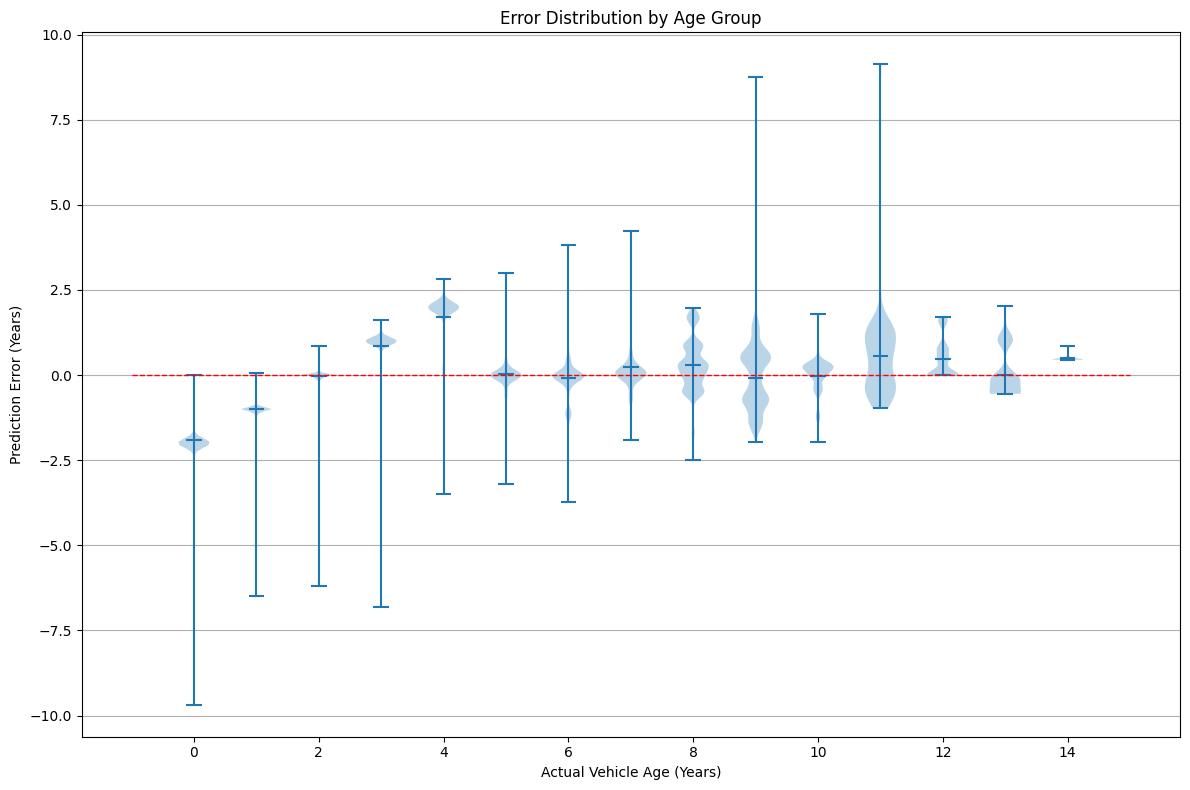

In [40]:
error = y_test - y_pred_best
y_test_rounded = np.round(y_test).astype(int)

error_by_age = {}
for age in np.unique(y_test_rounded):
    mask = y_test_rounded == age
    error_by_age[age] = error[mask]

min_samples = 10
filtered_ages = [age for age, errors in error_by_age.items() if len(errors) >= min_samples]
filtered_errors = [error_by_age[age] for age in filtered_ages]

plt.figure(figsize=(12, 8))
plt.violinplot(filtered_errors, positions=filtered_ages, showmeans=True)
plt.plot([min(filtered_ages)-1, max(filtered_ages)+1], [0, 0], 'r--', lw=1)
plt.xlabel('Actual Vehicle Age (Years)')
plt.ylabel('Prediction Error (Years)')
plt.title('Error Distribution by Age Group')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()